In [29]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [30]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

In [31]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from datetime import datetime 
import os.path

dsnum=100
verbose_level=1

In [32]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [33]:
pathds = os.path.abspath('/home/user/01Code/00Datasets_final/00BalancedDS')
file_name = "FullCloneID"+str(dsnum)+"bal_stdscal.csv"
full_path = os.path.join(pathds,file_name)
print(full_path)

/home/user/01Code/00Datasets_final/00BalancedDS/FullCloneID100bal_stdscal.csv


In [34]:
df = pd.read_csv(full_path)

In [35]:
df.shape

(2078832, 211)

In [36]:
neurons=df.shape[1]-1
batch_size=df.shape[1]-1
print(neurons)
print(batch_size)

210
210


#### 4.2 Explaining the data

In [37]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 1039416
Class 1: 1039416
Proportion: 1.0 : 1


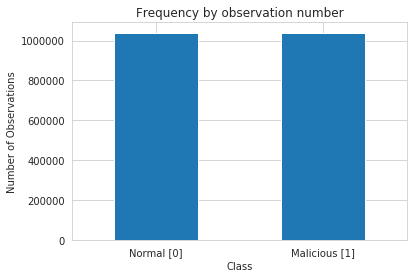

In [38]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [39]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [40]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [41]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [42]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, batch_size].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, batch_size].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, batch_size].sum()/test_df.shape[0])

0.49990228884619664
0.500260061993969
0.5001046259082611


In [43]:
train_x = train_df.iloc[:, :batch_size] 
dev_x = dev_df.iloc[:, :batch_size] 
test_x = test_df.iloc[:, :batch_size] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [44]:
# Define the final train and test sets
train_y = train_df.iloc[:,batch_size]
dev_y = dev_df.iloc[:,batch_size]
test_y = test_df.iloc[:,batch_size]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [45]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

210


### Autoencoder Function

In [46]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [47]:
def spae(factor_enc_dim,dec_activation,enc_activation,
         optimizer,loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [48]:
def to_pca(thr):
    #train_x_pca,test_x_pca = to_pca(0.95)
    pca = PCA(n_components = thr, svd_solver = 'full')
    train_x_ = np.array(train_x)
    print(type(train_x_))

    test_x_ = np.array(test_x)
    print(type(test_x_))
    
    start_time = time.time()
    print(time.ctime(start_time))

    train_x_pca = pca.fit_transform(train_x_)
    print(train_x_pca.shape)

    test_x_pca = pca.fit_transform(test_x_)
    print(test_x_pca.shape)

    elapsed_time = (time.time() - start_time)

    print("--- PCA spent %s seconds ---" %elapsed_time )
    
    return  train_x_pca,test_x_pca

In [49]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = datetime.now()
    print(datetime.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=verbose_level,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))
    
    return hist_auto

In [50]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [51]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [52]:
def ann_2h_():

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_dim,
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(int(neurons-int(neurons/4)), activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(int(neurons-int((neurons/4)*2)), activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [53]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=verbose_level)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = datetime.now()
    print(datetime.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping, cp, tb],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=verbose_level)

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

    return history

In [54]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [55]:
def ann_predict_():
    early_stopping = EarlyStopping(monitor='loss', patience=10)

    start_time = datetime.now()
    print(datetime.ctime(start_time))  

    modelk = KerasClassifier(build_fn=ann_2h_,
                             epochs=epochs, 
                             batch_size=batch_size, 
                             verbose=verbose_level
                            )

    pred_ann_prob = cross_val_predict(modelk,
                                      enc_test_x,
                                      test_y,
                                      cv=KFold(n_splits=5, random_state=23),
                                      verbose=1)

    time_elapsed = datetime.now() - start_time 
    print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)

    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob,pred_ann_01

In [56]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()

### **---------- PCA Dimensionality reduction ----------**

In [57]:
train_x_pca,test_x_pca = to_pca(0.95)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Tue Jul 16 14:50:45 2019
(1330452, 55)
(415767, 55)
--- PCA spent 97.33073353767395 seconds ---


### **---------- AE Dimensionality reduction ----------**

In [58]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 140)               29540     
_________________________________________________________________
dense_1 (Dense)              (None, 210)               29610     
Total params: 59,150
Trainable params: 59,150
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [60]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/ae_sigmoid_adam_mse_redds"+str(dsnum)+"bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Tue Jul 16 14:52:45 2019
Instructions for updating:
Use tf.cast instead.
Train on 1330452 samples, validate on 332613 samples
Epoch 1/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0533 - acc: 0.3265 - val_loss: 0.0512 - val_acc: 0.2283

Epoch 00001: val_loss improved from inf to 0.05117, saving model to ./H5files/ae_sigmoid_adam_mse_redds100bal.h5
Epoch 2/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0493 - acc: 0.2538 - val_loss: 0.0510 - val_acc: 0.2368

Epoch 00002: val_loss improved from 0.05117 to 0.05102, saving model to ./H5files/ae_sigmoid_adam_mse_redds100bal.h5
Epoch 3/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0492 - acc: 0.1764 - val_loss: 0.0510 - val_acc: 0.1724

Epoch 00003: val_loss improved from 0.05102 to 0.05100, saving model to ./H5files/ae_sigmoid_adam_mse_redds100bal.h5
Epoch 4/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0492 - a

Best loss value: 0.04916597103699353


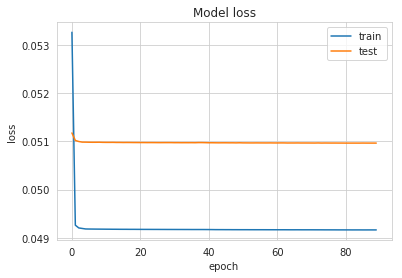

In [61]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

### **---------- SPAE Dimensionality reduction ----------**

In [62]:
spae_sigmoid_adam_mse,enc_train_x_spsam,enc_test_x_spsam = spae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 210)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 140)               29540     
_________________________________________________________________
dense_2 (Dense)              (None, 210)               29610     
Total params: 59,150
Trainable params: 59,150
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
#spae_sigmoid_adam_mse = load_model('spae_sigmoid_adam_mse_redds20bal.h5')

In [64]:
hist_spae_sigmoid_adam_mse = fit_ae(checkpoint_file = "./H5files/spae_sigmoid_adam_mse_redds"+str(dsnum)+"bal.h5",
                                  autoencoder = spae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = batch_size,
                                  shuffle = False)

Tue Jul 16 15:14:10 2019
Train on 1330452 samples, validate on 332613 samples
Epoch 1/200
1330452/1330452 [==============================] - 14s 10us/step - loss: 0.1342 - acc: 7.9672e-05 - val_loss: 0.0994 - val_acc: 3.9084e-05

Epoch 00001: val_loss improved from inf to 0.09935, saving model to ./H5files/spae_sigmoid_adam_mse_redds100bal.h5
Epoch 2/200
1330452/1330452 [==============================] - 13s 10us/step - loss: 0.0962 - acc: 3.5326e-05 - val_loss: 0.0976 - val_acc: 4.2091e-05

Epoch 00002: val_loss improved from 0.09935 to 0.09765, saving model to ./H5files/spae_sigmoid_adam_mse_redds100bal.h5
Epoch 3/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0954 - acc: 3.0817e-05 - val_loss: 0.0951 - val_acc: 2.7058e-05

Epoch 00003: val_loss improved from 0.09765 to 0.09509, saving model to ./H5files/spae_sigmoid_adam_mse_redds100bal.h5
Epoch 4/200
1330452/1330452 [==============================] - 14s 11us/step - loss: 0.0900 - acc: 1.6536e-05 - v

Best loss value: 0.08503769382842767


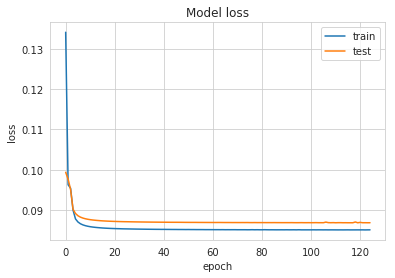

In [65]:
best_loss_value_spae_sigmoid_adam_mse  = plot_hist_auto(hist_spae_sigmoid_adam_mse, './Figures/hist_spae_sigmoid_adam_mse.png')

In [66]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_spae_sigmoid_adam_mse': best_loss_value_spae_sigmoid_adam_mse
    }

In [67]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_mse': 0.04916597103699353,
 'loss_value_spae_sigmoid_adam_mse': 0.08503769382842767}

In [68]:
print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_spsam.shape)
print(enc_test_x_spsam.shape)

(1330452, 140)
(415767, 140)
(1330452, 140)
(415767, 140)


### **---------- RF with ae encoded DS ----------**

In [69]:
from sklearn.ensemble import RandomForestClassifier

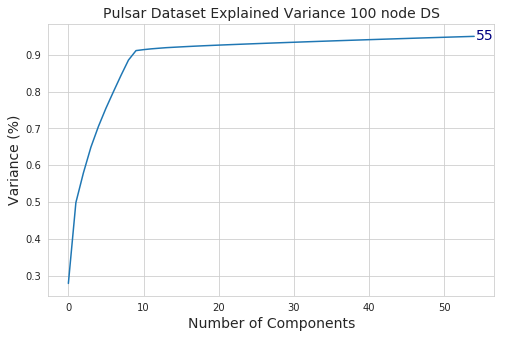

In [70]:
pca_ = PCA(n_components = 0.95, svd_solver = 'full').fit(train_x)

plt.figure(figsize=(8,5))
n_coml = [pca_.n_components_]

plt.plot(np.cumsum(pca_.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Variance (%)', fontsize=14) #for each component
plt.title('Pulsar Dataset Explained Variance '+str(dsnum)+' node DS', fontsize=14)

n_coml = [*n_coml]

for i, v in enumerate(n_coml):
    plt.text(v-0.8, i+0.94, '{:.0f}'.format(v), color='navy', fontsize=14)

plt.savefig('./Figures/PCA_components_ds'+str(dsnum)+'bal.png')
plt.show()

In [71]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
                             #min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [72]:
start_time = datetime.now()
print(datetime.ctime(start_time))

clf.fit(enc_train_x_asam, train_y)

pred_y_ae_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_asam),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

time_elapsed = datetime.now() - start_time 
print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

print(sm.classification_report(test_y, pred_y_ae_RF,digits=4))

Tue Jul 16 15:44:04 2019
Time elapsed (hh:mm:ss.ms) 8:03:43.066768
              precision    recall  f1-score   support

           0     0.9401    0.9918    0.9653    207840
           1     0.9914    0.9369    0.9633    207927

   micro avg     0.9643    0.9643    0.9643    415767
   macro avg     0.9657    0.9643    0.9643    415767
weighted avg     0.9657    0.9643    0.9643    415767



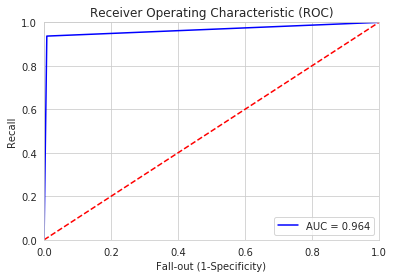

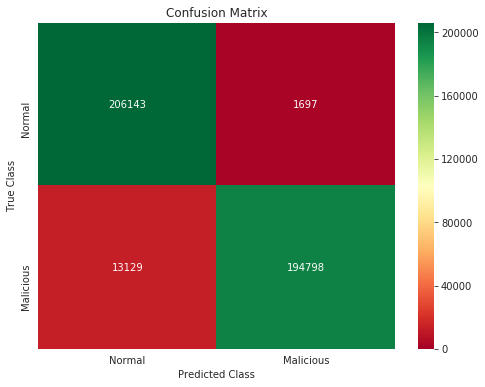

In [73]:
plot_roc_cm(pred_y_ae_RF, pred_y_ae_RF, './Figures/ROC_ae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_ae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

### **---------- RF with spae encoded DS ----------**

In [74]:
start_time = datetime.now()
print(datetime.ctime(start_time))

clf.fit(enc_train_x_spsam, train_y)

pred_y_spae_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_spsam),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

time_elapsed = datetime.now() - start_time 
print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

print(sm.classification_report(test_y, pred_y_spae_RF,digits=4))

Tue Jul 16 23:47:48 2019
Time elapsed (hh:mm:ss.ms) 7:49:16.161651
              precision    recall  f1-score   support

           0     0.9483    0.9886    0.9680    207840
           1     0.9881    0.9462    0.9667    207927

   micro avg     0.9674    0.9674    0.9674    415767
   macro avg     0.9682    0.9674    0.9673    415767
weighted avg     0.9682    0.9674    0.9673    415767



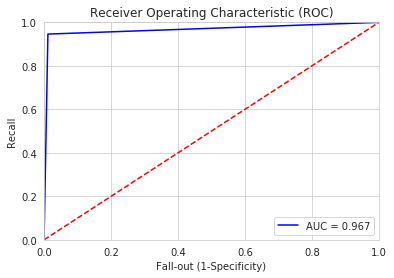

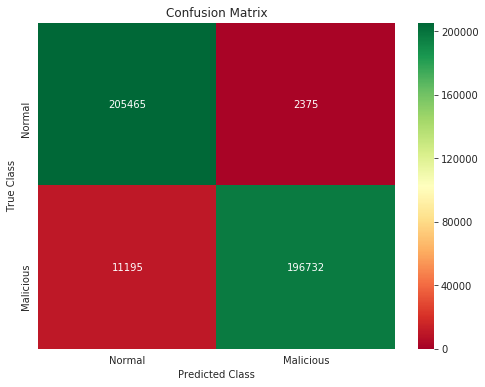

In [75]:
plot_roc_cm(pred_y_spae_RF, pred_y_spae_RF, './Figures/ROC_spae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_spae_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

### **---------- RF with pca DS ----------**

In [76]:
start_time = datetime.now()
print(datetime.ctime(start_time))

clf.fit(train_x_pca, train_y)

pred_y_pca_RF = cross_val_predict(estimator=clf,
                              X=np.array(test_x_pca),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

time_elapsed = datetime.now() - start_time 
print("Time elapsed (hh:mm:ss.ms) {}".format(time_elapsed))

print(sm.classification_report(test_y, pred_y_pca_RF,digits=4))

Wed Jul 17 07:37:05 2019
Time elapsed (hh:mm:ss.ms) 4:11:13.092356
              precision    recall  f1-score   support

           0     0.9377    0.9976    0.9667    207840
           1     0.9974    0.9337    0.9645    207927

   micro avg     0.9656    0.9656    0.9656    415767
   macro avg     0.9675    0.9656    0.9656    415767
weighted avg     0.9675    0.9656    0.9656    415767



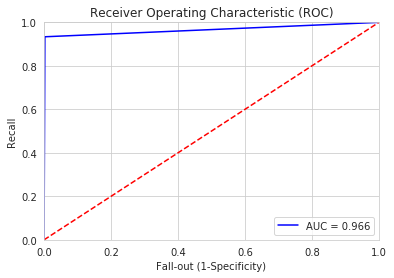

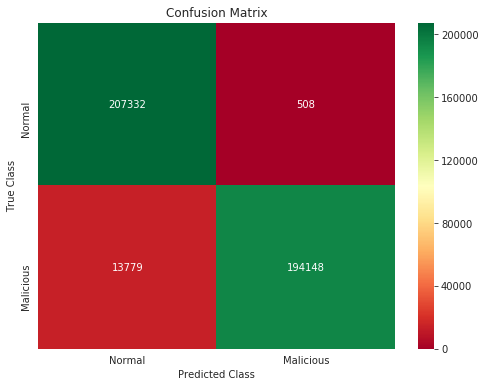

In [77]:
plot_roc_cm(pred_y_pca_RF, pred_y_pca_RF, './Figures/ROC_pca_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png', './Figures/CM_pca_rf_E100MaxfautoMaxdnoneBootT_redds'+str(dsnum)+'bal.png')

In [78]:
print(pred_y_ae_RF.shape)
print(pred_y_spae_RF.shape)
print(pred_y_pca_RF.shape)

(415767,)
(415767,)
(415767,)


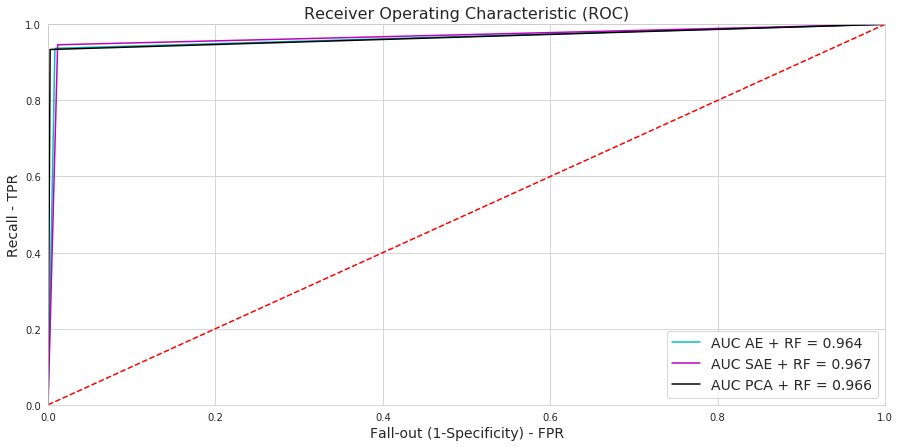

In [79]:
false_positive_rate_ae_RF, recall_ae_RF, thresholds_ae_RF = roc_curve(test_y, pred_y_ae_RF)
roc_auc_ae_RF = auc(false_positive_rate_ae_RF, recall_ae_RF)
false_positive_rate_spae_RF, recall_spae_RF, thresholds_spae_RF = roc_curve(test_y, pred_y_spae_RF)
roc_auc_spae_RF = auc(false_positive_rate_spae_RF, recall_spae_RF)
false_positive_rate_pca_RF, recall_pca_RF, thresholds_pca_RF = roc_curve(test_y, pred_y_pca_RF)
roc_auc_pca_RF = auc(false_positive_rate_pca_RF, recall_pca_RF)

plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)

plt.plot(false_positive_rate_ae_RF, recall_ae_RF, 'c', label = 'AUC AE + RF = %0.3f' %roc_auc_ae_RF)
plt.plot(false_positive_rate_spae_RF, recall_spae_RF, 'm', label = 'AUC SAE + RF = %0.3f' %roc_auc_spae_RF)
plt.plot(false_positive_rate_pca_RF, recall_pca_RF, 'black', label = 'AUC PCA + RF = %0.3f' %roc_auc_pca_RF)

plt.legend(loc='lower right', fontsize=14)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
# plt.ylim([0.97,1.0])

plt.ylabel('Recall - TPR', fontsize=14)
plt.xlabel('Fall-out (1-Specificity) - FPR', fontsize=14)
plt.savefig('./Figures/ROC_allRFmodels'+str(dsnum)+'bal.png')
plt.show()


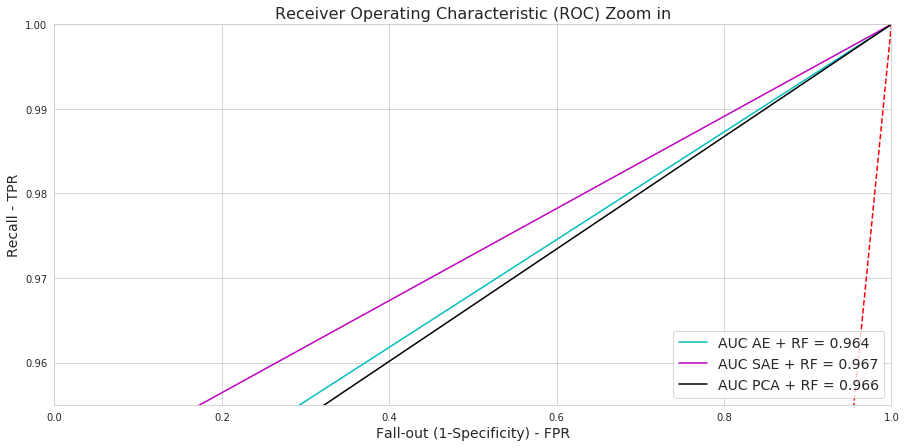

In [80]:
plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic (ROC) Zoom in', fontsize=16)

plt.plot(false_positive_rate_ae_RF, recall_ae_RF, 'c', label = 'AUC AE + RF = %0.3f' %roc_auc_ae_RF)
plt.plot(false_positive_rate_spae_RF, recall_spae_RF, 'm', label = 'AUC SAE + RF = %0.3f' %roc_auc_spae_RF)
plt.plot(false_positive_rate_pca_RF, recall_pca_RF, 'black', label = 'AUC PCA + RF = %0.3f' %roc_auc_pca_RF)

plt.legend(loc='lower right', fontsize=14)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.0])
plt.ylim([0.955,1.0])

plt.ylabel('Recall - TPR', fontsize=14)
plt.xlabel('Fall-out (1-Specificity) - FPR', fontsize=14)
plt.savefig('./Figures/ROC_allRFmodels'+str(dsnum)+'bal_zoom.png')
plt.show()

In [81]:
classi_ae_RF = "AE+RF"
acc_ae_RF = (sm.accuracy_score(test_y, pred_y_ae_RF)*100) 
pre_ae_RF = (sm.precision_score(test_y, pred_y_ae_RF)*100) 
recall_ae_RF = (sm.recall_score(test_y, pred_y_ae_RF)*100) 
f1score_ae_RF = (sm.f1_score(test_y, pred_y_ae_RF)*100)

classi_spae_RF = "SAE+RF"
acc_spae_RF = (sm.accuracy_score(test_y, pred_y_spae_RF)*100) 
pre_spae_RF = (sm.precision_score(test_y, pred_y_spae_RF)*100) 
recall_spae_RF = (sm.recall_score(test_y, pred_y_spae_RF)*100) 
f1score_spae_RF = (sm.f1_score(test_y, pred_y_spae_RF)*100)

classi_pca_RF = "PCA+RF"
acc_pca_RF = (sm.accuracy_score(test_y, pred_y_pca_RF)*100) 
pre_pca_RF = (sm.precision_score(test_y, pred_y_pca_RF)*100) 
recall_pca_RF = (sm.recall_score(test_y, pred_y_pca_RF)*100) 
f1score_pca_RF = (sm.f1_score(test_y, pred_y_pca_RF)*100)


print('Classifier\tAcc\tPreci\tRecall\tF1Score')
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_ae_RF, acc_ae_RF, pre_ae_RF, recall_ae_RF, f1score_ae_RF))
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_spae_RF, acc_spae_RF, pre_spae_RF, recall_spae_RF, f1score_spae_RF))
print('{0:}\t\t{1:.2f}\t{2:.2f}\t{3:.2f}\t{4:.2f}'.format(classi_pca_RF, acc_pca_RF, pre_pca_RF, recall_pca_RF, f1score_pca_RF))

Classifier	Acc	Preci	Recall	F1Score
AE+RF		96.43	99.14	93.69	96.33
SAE+RF		96.74	98.81	94.62	96.67
PCA+RF		96.56	99.74	93.37	96.45


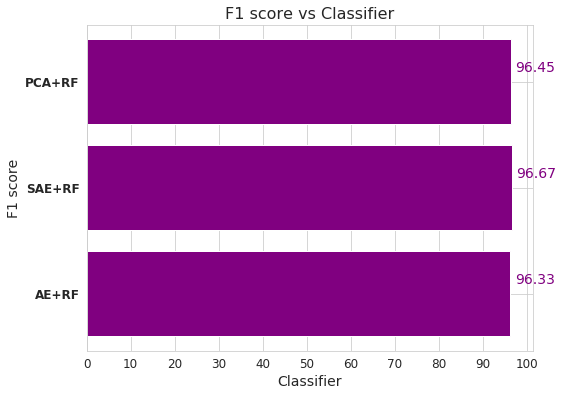

In [82]:
f1list = [["AE+RF",f1score_ae_RF],["SAE+RF",f1score_spae_RF],["PCA+RF",f1score_pca_RF]]

xs, ys = [*zip(*f1list)]

# '{:.2f}'.format(f1score_ae_ann)

plt.figure(figsize=(8,6), )
plt.barh(xs, ys, color = "purple")
plt.title("F1 score vs Classifier", fontsize=16)
plt.xlabel("Classifier", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.xticks(np.arange(0, 101, 10), fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')

for i, v in enumerate(ys):
    plt.text(v+1, i+0.1, '{:.2f}'.format(v), color='purple', fontsize=14)

plt.savefig('./Figures/F1scoreplot_allRFmodels'+str(dsnum)+'bal.png')
plt.show()